# The mouse behavior

## Picture of the box

## Video of mouse playing

## Example dataframe of how the data is stored (without previous rewards)

## Approach: optimal player is doing online inference in a hidden Markov model

## Learning the parameters from the mouse data

## Predicting mouse behavior

## Compare to Logistic Regression

### Import packages

In [92]:
from IPython.display import YouTubeVideo
from IPython.display import Image
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
import sklearn.tree
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline 

### In a life where both our world and ourselves are constantly changing, it can be hard to figure out what to do: should you rely on what has happened in the past to make a decision? or should you explore and try to learn something new?

### In reinforcement learning theory, this optimization problem is known as the 'explore-exploit' tradeoff, and was formalized in 1952 as the 'multi-armed bandit problem', where a gambler in front of a row of slot machines has to decide which machines to play, how many times to play each machine and in which order to play them.

### An optimal gambler will do 'online inference in a hidden Markov model' - where it accumates evidence from its actions and combines it with an expectation for how often the reward probabilities for each slot machine changes

### While animals (including humans!) make this type of decision all the time, it is not understood how our brain implements this decision process. Are there collections of neurons computing the very algorithms we discovered with math and statistics? Or have the organic circuits in our brain evolved to find an alternate solution? 

### This is the main project I'm working on right now! 



In [4]:
YouTubeVideo("5ecQ8w4K0aE")

In [5]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/harry_8020_high.csv',index_col=0)
print('This data contains %.0f trials from %.0f sessions' % (data.shape[0],np.unique(data['Session ID'].values).shape[0]))
print('First 5 data entries:')
data.head(5)

This data contains 3040 trials from 5 sessions
First 5 data entries:


,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward
0,harry,07252016_harry,11.0,1.0,-1.0,1.0,0.0,1.660,0.291,1.0,...,0.319,1.0,0.0,1.304,0.258,2.335,0.0,1.0,1.0,1.0
1,harry,07252016_harry,12.0,1.0,1.0,1.0,0.0,1.467,0.354,1.0,...,0.258,0.0,1.0,2.335,0.304,1.793,0.0,0.0,1.0,0.0
2,harry,07252016_harry,13.0,2.0,-1.0,1.0,0.0,1.490,0.320,1.0,...,0.304,0.0,0.0,1.793,0.261,1.613,0.0,0.0,1.0,0.0
3,harry,07252016_harry,14.0,3.0,-2.0,1.0,0.0,1.446,0.312,1.0,...,0.261,0.0,0.0,1.613,0.319,1.331,1.0,1.0,0.0,0.0
4,harry,07252016_harry,15.0,1.0,-3.0,1.0,0.0,2.453,0.266,1.0,...,0.319,1.0,0.0,1.331,0.428,1.545,1.0,0.0,0.0,0.0


### Some really important summary statistics: 
1. what is the overall percentage of trials that this mouse ('harry') chose the port with a higher reward probability?
2. what is the distribution of 'stays' (when a mouse returns to the same port it went to previously) and 'switches' (different from last choice)

In [6]:
sessions = np.unique(data['Session ID'].values) #the session IDs (useful for labelling plots below)

print('Number of sessions in dataset: %.0f' % sessions.shape[0])
print('Number of trials in dataset: %.0f' % data.shape[0])
print('Number of rewards recieved: %.0f' % data['Reward'].sum())
print('Number of switch trials %.0f' % data['Switch'].sum())

Number of sessions in dataset: 5
Number of trials in dataset: 3040
Number of rewards recieved: 2164
Number of switch trials 190


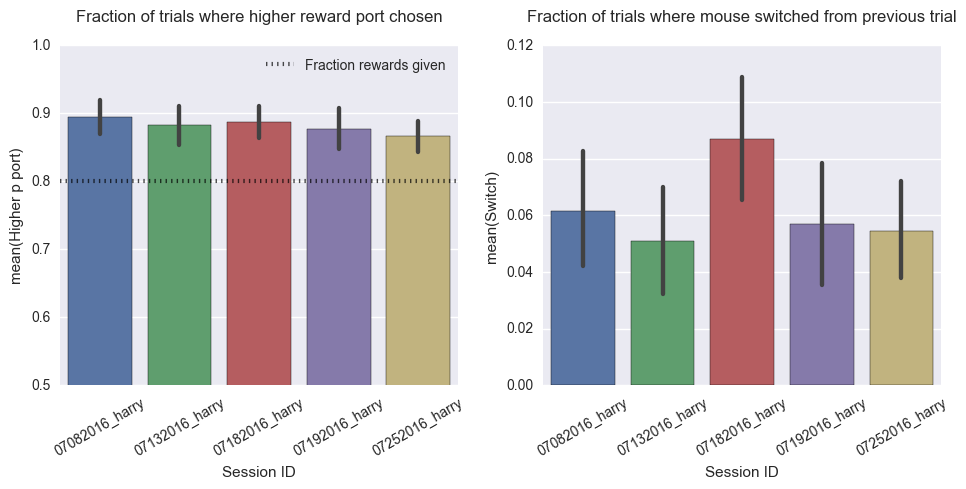

In [7]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,5))

plt.subplot(121)
ax = sns.barplot(x='Session ID',y='Higher p port',data = data)
ax.set_xticklabels(sessions,rotation=30)
plt.hlines(y=0.8,xmin=-0.5,xmax=5.5,color='black',linewidth=3,label='Fraction rewards given',alpha=0.7,linestyles='dotted')
plt.legend(loc='best')
plt.ylim(0.5,1)
plt.title('Fraction of trials where higher reward port chosen',x=0.5,y=1.05)

plt.subplot(122)
ax = sns.barplot(x='Session ID',y='Switch',data = data)
ax.set_xticklabels(sessions,rotation=30)
plt.title('Fraction of trials where mouse switched from previous trial',x=0.5,y=1.05)

plt.tight_layout()

Before we start to do anything complex ... what if the mice are simply implementing a 'win-stay, lose-switch' strategy?

In [8]:
print('Fraction of the time that a switch occured following an unrewarded trial: %.02f' % data[data['1_Reward'] == 0]['Switch'].mean() )

Fraction of the time that a switch occured following an unrewarded trial: 0.20


Nope! Something more complicated is going on here. 

## How are mice using information from the past to make a decision?

**Idea #1**: do logistic regression using previous trial outcomes as features to predict either 1) which port the mouse will choose or 2) whether a mouse will stay or switch

**Problem**: logistic regression fails to predict when a mouse will switch, even when:
    1. the decision boundary is optimized
    2. interaction terms between the previous trial outcomes are introduced
    3. a lot more data is used (up to 70,000 trials)
    
**Idea #2**: try predicting a mouse's decisions using the strategy of an optimal player: online inference in a hidden Markov model.

A hidden Markov model is a statistical system where there are multiple states connected with specific transition probabilities. These states cannot be directly observed (hence being 'hidden'), but can be estimated using evidence that is probabilistically related to which state the system is in (ie how frequently a reward is delivered).


Link to [Notebook 2](notebook2.ipynb)

## Hidden Markov model schematic

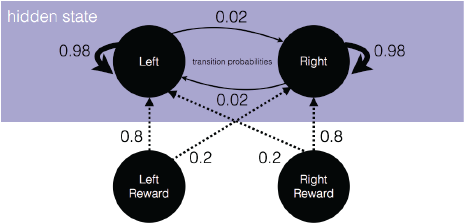

In [9]:
Image(filename='/Users/shayneufeld/GitHub/mouse_bandit/figures/hmm_schema.png')

Basic idea:
Belief in the latent state is computed by combining incoming information (ie. which port you just went to and if you got a reward) with your previous belief in the latent state and your knowledge of how often the latent state changes (how often the reward probabilites switch). 

That computation looks like:

$ b_{t+1} = \sum_k p(z_{t+1} | z_t=k)  * p(r_t | z_t = k, a_t) * b_{t,k} $

where:
- **b** - belief in the value of the latent state [left or right]
- **z** - the latent state [left or right]
- **r** - reward delivered [true or false]
- **a** - action performed [left or right]

# using a hidden Markov model to predict a mouse's decisions:

In [15]:
def hmm_predict(data,emission_prob,transition_prob,n_prev_trials=10):
    
    '''
    Tuned parameters
    '''
    p = emission_prob # prob of reward if choose the correct side
    q = 1.0-p # prob of reward if choose the incorrect side
    s = 1-transition_prob
    
    '''
    Set up outcome & transition matrices
    '''
    #transition matrix
    '''
    set transition matrix T such that T[i,j] is the probability of transitioning
    from state i to state j. 
    If the true number of trials before switching is 'duration', then set the
    probability of switching to be 1 / duration, and the probability of 
    staying to 1 - 1 / duration
    '''
    T = np.array([[s, 1.0-s],
                 [1.0-s,s]])

    #observation array
    '''
    set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

    eg. when action = L, observation matrix should be:
    O[:,:,1]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
                   P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
                = [1-p, 1-q
                    p,   q]
    '''
    O = np.zeros((2,2,2))
    # let a 'right' choice be represented by '0'
    O[:,:,0] = np.array([[1.0-p, 1.0-q],
                         [p,q]])
    O[:,:,1] = np.array([[1.0-q, 1.0-p],
                         [q,p]])
    
    #set test data
    data_test = data.copy()
    #extract number of trials in dataset
    n_trials = data_test.shape[0]
    
    #extract relevant features
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)
    
    port_features = port_features[-n_prev_trials:]
    reward_features = reward_features[-n_prev_trials:]
    
    #initialize prediction array
    y_predict = np.zeros(n_trials)
    likeli = []
    master_beliefs = np.zeros(n_trials)
    
    #loop through each trial
    for trial in range(data_test.shape[0]):
        curr_trial = data_test.iloc[trial]
        actions = curr_trial[port_features].values
        rewards = curr_trial[reward_features].values
        beliefs = np.nan*np.ones((n_prev_trials+1,2))
        beliefs[0] = [0.5,0.5] #initialize both sides with equal probability
        #run the algorithm
        for play in range(n_prev_trials):

            assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"

            #update neg log likelihood
            likeli.append(-1*np.log(beliefs[play,actions[play]]))

            #update beliefs for next play
            #step 1: multiply by p(r_t | z_t = k, a_t)
            belief_temp = O[rewards[play],:,actions[play]] * beliefs[play]

            #step 2: sum over z_t, weighting by transition matrix
            beliefs[play+1] = T.dot(belief_temp)

            #step 3: normalize
            beliefs[play+1] /= beliefs[play+1].sum()

        #predict action
        y_predict[trial] = np.where(beliefs[-1] == beliefs[-1].max())[0][0]
        master_beliefs[trial] = beliefs[-1].max()
        
    return y_predict

## Using the hidden Markov model to predict a mouse's decisions

In [16]:
y_predict = hmm_predict(data,0.8,0.02)
y_test = data['Decision'].values

prev_port_test = data['1_Port'].values

#switches
y_test_switch = np.abs(y_test - prev_port_test)
y_predict_switch = np.abs(y_predict - prev_port_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=True)

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


          Predicted NO  Predicted YES
True NO         2656.0          194.0
True YES          69.0          121.0

F1: 0.479

Accuracy on class 0: 0.93
Accuracy on class 1: 0.64



## Compare to baseline 'win-stay lose-switch model'

In [105]:
y_predict_triv = data['1_Reward'].values == 0
y_test = data['Decision'].values

prev_port_test = data['1_Port'].values

#switches
y_test_switch = np.abs(y_test - prev_port_test)
y_predict_switch = np.abs(y_predict_triv - prev_port_test)
acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_triv,y_test_switch,confusion=False,disp=True)

          Predicted NO  Predicted YES
True NO         2149.0          701.0
True YES          14.0          176.0

F1: 0.330

Accuracy on class 0: 0.75
Accuracy on class 1: 0.93



In [17]:
acc_switches,acc_stays,F1 = [],[],[]

for num_trials in np.arange(1,11):
    y_predict = hmm_predict(data,0.8,0.02,n_prev_trials=num_trials)
    prev_port_test = data['1_Port'].values
    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,f=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=False)
    acc_switches.append(acc_pos)
    acc_stays.append(acc_neg)
    F1.append(f)

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:78: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


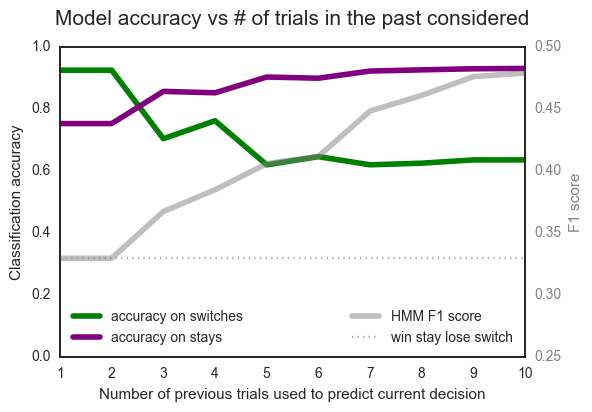

In [87]:
sns.set_style('white')
x = np.arange(1,11)
plt.figure(figsize=(5,5))
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

ax2.plot(x,F1,color='grey',label = 'HMM F1 score',linewidth=4,alpha=0.5)
ax2.hlines(y=0.33,xmin=1,xmax=10,color='grey',alpha=0.6,linestyle='dotted',label='win stay lose switch')
ax1.plot(x,acc_switches,color='green',label='accuracy on switches',linewidth=4)
ax1.plot(x,acc_stays,color='purple',label='accuracy on stays',linewidth=4)
ax1.set_ylim(0,1)
ax2.set_ylim(0.25,0.5)
ax1.set_xlabel('Number of previous trials used to predict current decision')
ax1.set_ylabel('Classification accuracy')
ax2.set_ylabel('F1 score',color='grey')
ax1.legend(loc='best')
ax2.legend(loc='lower right')
ax2.tick_params(axis='y',colors='grey')
plt.title('Model accuracy vs # of trials in the past considered',fontsize=15,x=0.5,y=1.05)

# Other stuff in case the conversation goes that way...

In [53]:
def train_hmm(data_train,emission_probs,transition_probs,num_trials=10):
    '''
    Computes the most likely emission & transition probabilities for the hidden Markov model based on the training set.
    For every trial, the model computes the belief in the latent state for the t+1 trial. The likelihood for that trial
    is defined as the belief the model had in the action chosen by the mouse. IE if the model had belief = 0.7 for
    the left port, and the mouse chose left, the likelihood for the model with those parameters for that trial is 0.7
    
    The model cycles through the data and sums the likelihood for each combination of emission and transition
    probabilities.
    
    Inputs
        - data_train         - pandas dataframe training set
        - num_trials         - number of trials in the past to consider when computing belief
        - emission_probs     - range of emission probabilites to try
        - transition probs   - range of transition probabilites to try
    Ouputs
        - [optimal_emmission, optimal_transition] - the parameters most likely under the training data
    
    '''
    
    #make a copy of the data to work with
    data = data_train.copy()
    n_trials = data.shape[0] #number of trials in training set
    
    '''
    PARAMETERS TO TUNE
    '''
    
    likeli_df = pd.DataFrame(columns=['Likeli','p','t'])
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)
            
    #loop through parameters
    for p in emission_probs:
        
        q = 1.0-p # prob of reward if choose the incorrect side

        for t in transition_probs:
            '''
            Set up transition matrix and observation matrix
            '''
            #transition matrix
            s = 1 - 1./t
            T = np.array([[s, 1.0-s],
                         [1.0-s,s]])
            #observation matrix
            '''
            set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

            eg. when action = R, observation matrix should be:
            O[:,:,0]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
                           P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
                        = [1-p, 1-q
                            p,   q]
            '''
            O = np.zeros((2,2,2))
            # let a 'right' choice be represented by '0'
            O[:,:,0] = np.array([[1.0-p, 1.0-q],
                                 [p,q]])
            O[:,:,1] = np.array([[1.0-q, 1.0-p],
                                 [q,p]])

            #TEST: All conditional probability distributions must sum to one
            #assert np.allclose(O.sum(0),1), "All conditional probability distributions must sum to one!
            '''
            run game
            '''
            likeli = []
            
            for trial in range(n_trials):

                curr_trial = data_test.iloc[trial]
                actions = curr_trial[port_features].values
                rewards = curr_trial[reward_features].values
                beliefs = np.nan*np.ones((num_trials+1,2))
                beliefs[0] = [0.5,0.5] #initialize both sides with equal probability
                
                #run the algorithm
                for play in range(num_trials):

                    assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"

                    #update neg log likelihood
                    likeli.append(-1*np.log(beliefs[play,actions[play]]))

                    #update beliefs for next play
                    #step 1: multiply by p(r_t | z_t = k, a_t)
                    belief_temp = O[rewards[play],:,actions[play]] * beliefs[play]

                    #step 2: sum over z_t, weighting by transition matrix
                    beliefs[play+1] = T.dot(belief_temp)

                    #step 3: normalize
                    beliefs[play+1] /= beliefs[play+1].sum()

                #update neg log likelihood
                likeli.append(-1*np.log(beliefs[-1,actions[-1]]))
                    
            d = {'Likeli':np.sum(likeli),'p':p,'t':t}

            likeli_df = likeli_df.append(pd.DataFrame(data=d,index=[0]))
           
        optimal_emmission = likeli_df[likeli_df['Likeli'] == likeli_df['Likeli'].min()]['p'].values
        optimal_transition = likeli_df[likeli_df['Likeli'] == likeli_df['Likeli'].min()]['t'].values
    
    return [optimal_emmission,optimal_transition,likeli_df]

In [88]:
def logreg_and_eval_withports_and_interactions(data,num_rewards=10,num_ports=1,test_data=False,interaction_deg=4):
    '''
    Perform Logistic Regression on a pandas dataframe of trials (from feature matrix) with interactions
    
    Inputs:
        - data: pandas dataframe of trials (from feature matrix)
    Outputs:
        - logreg: trained logistic regression model (from sklearn)
        - stats:  pandas dataframe with F1, pseudo-R2, and BIC scores from model
        - coeffs: beta coefficients from logreg
    
    '''
    
    from statsmodels.discrete.discrete_model import Logit
    
    port_features = []
    reward_features = []

    #change right port to -1 instead of 0
    for col in data:
        if '_Port' in col:
            data.loc[data[col] == 0,col] = -1
            port_features.append(col)
        elif '_Reward' in col:
            reward_features.append(col)

    #create new feature matrix
    d = data.copy()
    for i in range(len(port_features)):
        d[reward_features[i]] = d[reward_features[i]].values*d[port_features[i]].values
    
    
    #determine the features
    features = reward_features.copy()
    if num_rewards == 0:
        features = port_features[-1*num_ports:]
    elif num_ports == 0:
        features = features[-1*num_rewards:] #only take the num of rewards specificied in the function
    else:
        features = features[-1*num_rewards:]
        features = np.append(features,port_features[-1*num_ports:])
    
    print(features)
    features = np.append(features,'Decision') #finally append the decision so we can take it to predict later
    
    
    
    #final version of data
    d = d[features].copy() #this now just has the features we want and the decision we want to predict
    
    #do the same thing for the test data if it exists!
    if test_data is not False:
        for col in test_data:
            if '_Port' in col:
                test_data.loc[test_data[col] == 0,col] = -1

        #create new feature matrix
        data_test_new = test_data.copy()
        for i in range(len(port_features)):
            data_test_new[reward_features[i]] = test_data[reward_features[i]].values*test_data[port_features[i]].values
        
        d_test = data_test_new[features].copy()
    
    
        #set training and testing sets now
        x_train = d.iloc[:,:-1].values
        y_train = d.iloc[:,-1].values
        x_test = d_test.iloc[:,:-1].values
        y_test = d_test.iloc[:,-1].values
        
        prev_port_test = test_data['1_Port'].values
        prev_port_test[prev_port_test==-1] = 0
    
    #if there is no test data, then split up the data into training and testing
    else:
        #extract features and decisions
        x = d.iloc[:,:-1].values
        y = d.iloc[:,-1].values

        #split into training and testing
        n_trials = x.shape[0]
        shuf_inds = np.random.permutation(n_trials)
        split_ind = int(n_trials*0.7)

        x_train = x[shuf_inds[:split_ind],:]
        y_train = y[shuf_inds[:split_ind]]

        x_test = x[shuf_inds[split_ind:],:]
        y_test = y[shuf_inds[split_ind:]]
        
        #extract previous port decision for test set
        #these will be used to calculate switches on the test predictions
        prev_port_test = data['1_Port'].values[shuf_inds[split_ind:]]
        prev_port_test[prev_port_test==-1] = 0
    
    '''
    Modeling
    '''
    
    #create interaction terms
    poly = PolynomialFeatures(degree=interaction_deg,interaction_only=True,include_bias=True)
    x_train = poly.fit_transform(x_train)
    x_test = poly.fit_transform(x_test)
    print('x_train shape: %.0f' % x_train.shape[1])
    
    
    #fit logistic regression
    logreg = sklearn.linear_model.LogisticRegressionCV()
    logreg.fit(x_train,y_train)
    
    #predict on testing set
    y_predict = logreg.predict(x_test)
    y_predict_proba = logreg.predict_proba(x_test)
    
    #model accuracy
    score = logreg.score(x_test,y_test)
    
    #calculating pseudo-R2 and BIC from statsmodel OLS
    model = Logit(y_train,x_train)
    rslt  = model.fit()

    #switches
    y_test_switch = np.abs(y_test - prev_port_test)
    y_predict_switch = np.abs(y_predict - prev_port_test)
    acc_pos,acc_neg,F1=sf.score_both_and_confuse(y_predict_switch,y_test_switch,confusion=False,disp=False)
    
    #extract coefficients
    coefs = logreg.coef_ #retrieve coefs
    coefs = np.append(coefs[0],logreg.intercept_) #add bias coef
    
    #create stats database to return
    d_ = {'pseudo-R2':rslt.prsquared,'stay':acc_pos,'switch':acc_neg,'Accuracy':score,'BIC':rslt.bic,'negative loglikelihood':-1*rslt.llf}
    stats = pd.DataFrame(data=d_,index=[0])
    features = features[:-1]
    features = np.append(features,'Bias')
    
    #coefs = pd.DataFrame(data=coefs.reshape(1,-1),columns=poly.get_feature_names())
    return logreg,stats

# Logistic Regression [L2]

In [ ]:
model,stats = logreg_and_eval_withports_and_interactions(data,num_rewards=10,num_ports=1,test_data=False,interaction_deg=1)